# Tasty Bites: Analysis and Machine Learning Solution

# Data Validation
The provided dataset had 947 entries across 8 columns, 5 of which columns contained some missing values. After validation, 892 entries and 8 columns remain.

1. recipe: validated all 947 entries as unique identifiers
2. calories: logically validated using descriptive statistics, removed 52 entries with missing values
3. carbohydrate: logically validated using descriptive statistics, removed 52 entries with missing values
4. sugar: logically validated using descriptive statistics, removed 52 entries with missing values
5. protein: logically validated using descriptive statistics, removed 52 entries with missing values
6. category: consolidated 'Chicken Breast' with 'Chicken' and converted to 'category' data type, resulting in the 10 provided possible groupings
7. servings: removed 3 entries with ambiguous interpretability, converted to int64 and logically validated the remaining values
8. high_traffic: validated target variable as binary and encoded as Boolean (NaN = False, 'High' = True)

In [3]:
# Import necessary base modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Import data
letmecook = pd.read_csv('recipe_site_traffic_2212.csv')

# Initial impressions
print(letmecook.info(),'\n')
# 947 entries across 8 columns

print(f'Columns with missing values: {letmecook.isna().any().sum()}')
# 5 columns have missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB
None 

Columns with missing values: 5


In [5]:
letmecook.describe()
# Numeric values appear initially sensible
# Some features have more variation than other

,recipe,calories,carbohydrate,sugar,protein
count,947.000000,895.000000,895.000000,895.000000,895.000000
mean,474.000000,435.939196,35.069676,9.046547,24.149296
std,273.519652,453.020997,43.949032,14.679176,36.369739
min,1.000000,0.140000,0.030000,0.010000,0.000000
25%,237.500000,110.430000,8.375000,1.690000,3.195000
50%,474.000000,288.550000,21.480000,4.550000,10.800000
75%,710.500000,597.650000,44.965000,9.800000,30.200000
max,947.000000,3633.160000,530.420000,148.750000,363.360000


## Recipe (Unique Identifier)
Confirmed all 947 entries of 'recipe' column are unique values.

In [6]:
# recipe: validate unique numeric identifier
letmecook['recipe'].is_unique

True

## High Traffic (Target Variable)
Confirmed `high_traffic` column represents a binary outcome. I encoded as Boolean: NaN = False, 'High' = True.

In [7]:
# high_traffic: validate binary target variable
letmecook['high_traffic'].value_counts(dropna=False)

# encode as boolean: 'High' = True
letmecook['high_traffic'] = np.where(letmecook['high_traffic'].isna(),False,True)
letmecook['high_traffic'].value_counts()

True     574
False    373
Name: high_traffic, dtype: int64

## Category
Found 11 unique values in `category`. Unique values included the 10 possible groupings that were provided as well as 'Chicken Breast'. I consolidated 'Chicken Breast' into the 'Chicken' grouping and converted the column to a nominal categorical variable.

In [8]:
# category: validate 10 unique categories
print(letmecook['category'].nunique())
print(letmecook['category'].value_counts())

# consolidate 'Chicken Breast' into 'Chicken' category
letmecook.loc[letmecook['category'].isin(['Chicken Breast']),'category'] = 'Chicken'
letmecook['category'].value_counts()

# convert to categorical and validate specific provided category names
letmecook['category'] = pd.Categorical(letmecook['category'], categories=['Lunch/Snacks', 'Beverages', 'Potato',
'Vegetable', 'Meat', 'Chicken', 'Pork', 'Dessert', 'Breakfast', 'One Dish Meal'])

letmecook['category'].value_counts()

11
Breakfast         106
Chicken Breast     98
Beverages          92
Lunch/Snacks       89
Potato             88
Pork               84
Vegetable          83
Dessert            83
Meat               79
Chicken            74
One Dish Meal      71
Name: category, dtype: int64


Chicken          172
Breakfast        106
Beverages         92
Lunch/Snacks      89
Potato            88
Pork              84
Vegetable         83
Dessert           83
Meat              79
One Dish Meal     71
Name: category, dtype: int64

## Servings
The `servings` column contains 947 entries, none of them missing. While a vast majority simply contain integers (1, 2, 4, or 6),  three entries include 'n as a snack', with either 4 or 6 as 'n'.

- It is unclear how 'n' number of servings 'as a snack' can be interpreted in comparison to the other values.
- To indirectly determine if there is a difference in value weight, I compared these values to `calories`. I found 'as a snack' recipes have a much higher number of calories on average. The "Example Recipe" provided indicates nutritional values are represented as "per serving", so this observation appears contrary to what might be expected for calories from a snack compared to a meal. This was observed on both the categorical level (all 'as a snack' values exist in `category` == 'Lunch/Snacks') and overall.
    - With such a small sample size, it is unknown but improbable that the 'as a snack' values would provide any significant feature importance or be correlated with other known/unknown variables.

Due to the above, and because they make up less than 4% of within-category values, I have at this time elected to drop the 3 entries containing 'n as a snack' without further exploration. 

I finished validation of `servings` by converting the column values to 'int64' so their weight can be properly expressed and interpreted.

In [9]:
# view counts of all values
print(letmecook['servings'].value_counts(),'\n')

# 'as a snack'
as_snack = letmecook.loc[letmecook['servings'].isin(['4 as a snack', '6 as a snack']), :]
as_snack['servings'] = as_snack['servings'].str.replace(' as a snack', '').astype('int')
as_snack_mean = as_snack['calories'].mean()

# 'Lunch/Snacks' category without 'as a snack'
no_snack = letmecook.loc[~letmecook['servings'].isin(['4 as a snack', '6 as a snack']), :]
no_snack['servings'] = no_snack['servings'].astype('int')
lunch_snacks_mean = no_snack.loc[no_snack['category'] == 'Lunch/Snacks','calories'].mean()

# total calories (all categories) without 'as a snack'
cal_mean = no_snack['calories'].mean()

# Mean calories 'as a snack', 'Lunch/Snacks', and overall (exclusive)
print(f'Average calories: \n"as a snack": {round(as_snack_mean)} \n"Lunch/Snacks": {round(lunch_snacks_mean)} \nAll categories: {round(cal_mean)}\n')

# 'as a snack' entries <5% both total entries and 'Lunch/Snack' category entries
num_as_snack = as_snack['calories'].count()
num_cat = letmecook.loc[letmecook['category'] == 'Lunch/Snacks','calories'].count()

print(f'"as a snack" entries account for {round((num_as_snack/num_cat) * 100, 2)}% of "Lunch/Snacks" category ({num_as_snack}/{num_cat})')

# drop 'as a snack' entries
letmecook.drop(letmecook[letmecook['servings'].isin(['4 as a snack', '6 as a snack'])].index, inplace=True)

# cast remaining values as integer one more time
letmecook['servings'] = letmecook['servings'].astype('int')

letmecook['servings'].value_counts()

4               389
6               197
2               183
1               175
4 as a snack      2
6 as a snack      1
Name: servings, dtype: int64 

Average calories: 
"as a snack": 1166 
"Lunch/Snacks": 453 
All categories: 433

"as a snack" entries account for 3.66% of "Lunch/Snacks" category (3/82)


4    389
6    197
2    183
1    175
Name: servings, dtype: int64

## Calories, Carbohydrate, Sugar, Protein (Missingness)
There are 52 entries where the numeric values are completely missing across all 4 columns: `calories`, `carbohydrate`, `sugar`, and `protein`.

These missing entries make up more than 5% of the total data and initially did not appear to be missing completely at random (MCAR); a statistically significant difference in proportions of recipes that were `high_traffic` was substantiated using a Welch's t-test between recipes that were missing vs. not-missing values in these 4 numeric columns. 

However, the only additional feature information lost from dropping these would be from `category` and `servings` columns (`recipe` is unique identifier column and `high_traffic` is target variable). To justify this, I evaluated the relationship between missingness of numeric data within the remaining columns with respect to the target variable. 

In [10]:
# count of missing values by column
missing_by_col = letmecook.isna().sum()
print(missing_by_col,'\n')

# in 52 entries, calories, carbohydrate, sugar, and protein values are all missing
calories_null = letmecook.loc[letmecook['calories'].isna(), ['calories', 'carbohydrate', 'sugar', 'protein']]
print(calories_null.isna().sum(),'\n')

# missing entries account for >5% of data
missing_pct = letmecook['calories'].isna().mean()
print(f'Percentage of data missing: {round((missing_pct * 100),2)}%')

recipe           0
calories        52
carbohydrate    52
sugar           52
protein         52
category         0
servings         0
high_traffic     0
dtype: int64 

calories        52
carbohydrate    52
sugar           52
protein         52
dtype: int64 

Percentage of data missing: 5.51%


In [11]:
# proportion of high traffic recipes appears significantly different
missing_high_prop = letmecook.groupby(letmecook['calories'].isna())['high_traffic'].mean()
print(f'Proportion high_traffic when calories is not/is missing: \n{missing_high_prop}\n')

# substantiating difference in mean using Welch's t-Test
from statistics import variance
from scipy.stats import ttest_ind

alpha=0.05
print(f'alpha: {alpha}')

samp_missing = letmecook.loc[letmecook['calories'].isna(),'high_traffic']
samp_not_missing = letmecook.loc[~letmecook['calories'].isna(),'high_traffic']

ttest_missing = ttest_ind(samp_missing, samp_not_missing)

print(f'p-value: {round(ttest_missing[1],3)}')

# this cannot overall be contributed to chance alone and makes up more than 5%

Proportion high_traffic when calories is not/is missing: 
calories
False    0.597534
True     0.750000
Name: high_traffic, dtype: float64

alpha: 0.05
p-value: 0.029


In [12]:
# function to evaluate missingness, returning dictionaries to display as DataFrame
def evaluate_missing(column):
    """Takes categorical input column, evaluating percent missingness of numeric data between groups and with respect to target variable outcome."""
    pct_missing_dict = {}
    as_cat = letmecook.copy()
    as_cat[column] = as_cat[column].astype('category')
    for category in as_cat[column].cat.categories:
        grouped = as_cat.loc[as_cat[column] == category, 'calories']
        pct_missing = grouped.isna().mean()
        pct_missing = round((pct_missing * 100),2)
        pct_missing_dict[category] = pct_missing
    pct_high_dict = {}
    for category in as_cat[column].cat.categories:
        grouped = as_cat.loc[as_cat[column] == category, 'high_traffic']
        cat_prop = grouped.mean()
        cat_prop = round((cat_prop * 100),2)
        pct_high_dict[category] = cat_prop
    missing_pct_high_dict = {}
    for category in as_cat[column].cat.categories:
        grouped = as_cat.loc[as_cat[column] == category, ['calories', 'high_traffic']]
        pct_missing = grouped.loc[grouped['calories'].isna(), 'high_traffic'].mean()
        pct_missing = round((pct_missing * 100),2)
        missing_pct_high_dict[category] = pct_missing
    pct_nonmissing_high_dict = {}
    for category in as_cat[column].cat.categories:
        grouped = as_cat.loc[as_cat[column] == category, ['calories', 'high_traffic']]
        pct_nonmissing = grouped.loc[~grouped['calories'].isna(), 'high_traffic'].mean()
        pct_nonmissing = round((pct_nonmissing * 100),2)
        pct_nonmissing_high_dict[category] = pct_nonmissing
    return [pct_missing_dict, pct_high_dict, missing_pct_high_dict, pct_nonmissing_high_dict]
# note: could have used unique() values instead of converting to categorical data, but this works without having to take extra step of sorting

### Within-Category Missingness
The DataFrame below, missing_bycat, displays the results of my function evaluate_missing('category') by category:
- `pct_missing`: percentage of total values missing (within category)
- `pct_high`: percentage of recipes that resulted in 'high_traffic'
- `pct_missing_high`: percentage with missing numeric values that resulted in 'high_traffic'
- `pct_nonmissing_high`: percentage with non-missing numeric values that resulted in 'high_traffic'

Results: missing_bycat:
- Some food groupings appear to have a higher frequency of missing numeric data, with 'Pork' being the highest, at 13.10%. Two categories are not missing any numeric data at all ('Beverages', 'Breakfast').
- The proportion of recipes that are `high_traffic` vary between categories.
- While the proportion of recipes that result in `high_traffic` appear to vary when numeric values are missing, these small sample sizes do not appear to exert enough influence to manifest a significant difference between the total catagory-specific `high_traffic` proportion and the `high_traffic` proportion for entries in that category _without_ missing numeric data. This is substantiated using 1samp t-testing.


This has been repeated for the other remaining column, 'servings', that has similar results without any initially notable differences.

In [13]:
# evaluate and display missingness by 'category'
missing_by_cat = evaluate_missing('category')
results_by_cat = pd.DataFrame(missing_by_cat, index=['pct_missing', 'pct_high', 'pct_missing_high', 'pct_nonmissing_high']).T
print('By Food Grouping: \n',results_by_cat,'\n')

missing_by_serv = evaluate_missing('servings')
results_by_serv = pd.DataFrame(missing_by_serv, index=['pct_missing', 'pct_high', 'pct_missing_high', 'pct_nonmissing_high']).T
print('By Number of Servings: \n',results_by_serv)

By Food Grouping: 
                pct_missing  pct_high  pct_missing_high  pct_nonmissing_high
Lunch/Snacks          8.14     63.95             71.43                63.29
Beverages             0.00      5.43               NaN                 5.43
Potato                5.68     94.32            100.00                93.98
Vegetable             6.02     98.80            100.00                98.72
Meat                  6.33     74.68             60.00                75.68
Chicken               5.23     42.44             44.44                42.33
Pork                 13.10     91.67            100.00                90.41
Dessert               7.23     63.86             83.33                62.34
Breakfast             0.00     31.13               NaN                31.13
One Dish Meal         5.63     73.24             25.00                76.12 

By Number of Servings: 
    pct_missing  pct_high  pct_missing_high  pct_nonmissing_high
1         3.43     58.86             66.67           

### Hypothesis Testing
Null Hypothesis: 
- `high_traffic` proportion of non-missing entries ('pct_nonmissing_high' is sample prop) is not significantly different from the `high_traffic` proportion for all of the entries in that category, missing or not ('pct_high' is population prop).

Alternative Hypothesis:
- `high_traffic` proportion of non-missing entries ('pct_nonmissing_high' is sample prop) is significantly different from the `high_traffic` proportion for all of the entries in that category, missing or not ('pct_high' is population prop).

None of the p-values from the 1-sample t-tests are below the significance level, alpha, indicating that there is not enough evidence in the difference between the population proportion and sample proportion to attribute these differences to anything but chance alone. This further substantiates the evidence obtained earlier that individual feature importance of `category` and `servings` will not be significantly alterred or misrepresented by dropping the entries that have missing numeric data in `calories`, `carbohydrate`, `sugar`, and `protein`.

In [14]:
# run t-test comparing pct_high to pct_nonmissing_high
from scipy.stats import ttest_1samp

# establish alpha once again
print(f'alpha: {alpha} \n')

# ttest_1samp 'category' column
print(f'Food Category p-values: ')
for category in letmecook['category'].cat.categories:
    grouped = letmecook.loc[letmecook['category'] == category, ['calories', 'high_traffic']]
    pop_mean = grouped['high_traffic'].mean()
    sample = grouped.loc[~grouped['calories'].isna(), 'high_traffic']
    p_val = ttest_1samp(sample, popmean=pop_mean)[1]
    p_val = round(p_val,3)
    print(f'{category}: {p_val}')
print('')

# ttest_1samp 'servings' column
print(f'Number of Servings p-values: ')
for category in np.sort(letmecook['servings'].unique()):
    grouped = letmecook.loc[letmecook['servings'] == category, ['calories', 'high_traffic']]
    pop_mean = grouped['high_traffic'].mean()
    sample = grouped.loc[~grouped['calories'].isna(), 'high_traffic']
    p_val = ttest_1samp(sample, popmean=pop_mean)[1]
    p_val = round(p_val,3)
    print(f'{category}: {p_val}')

alpha: 0.05 

Food Category p-values: 
Lunch/Snacks: 0.904
Beverages: 1.0
Potato: 0.897
Vegetable: 0.952
Meat: 0.844
Chicken: 0.977
Pork: 0.719
Dessert: 0.786
Breakfast: 1.0
One Dish Meal: 0.585

Number of Servings p-values: 
1: 0.942
2: 0.78
4: 0.795
6: 0.697


### Final Thoughts on Missingness
While this my best solution, it should be emphasized that this is still not completely optimal. Between groups, there appears to be variance in the proportion of missing values, as discussed earlier, which could result in some misrepresentation of the numeric data columns `calories`, `carbohydrate`, `sugar`, and `protein` if they prove to be of importance, but the values of these columns also greatly vary, both within and between groups.

This is displayed in the DataFrame below, cals_by_cat, which provides descriptive statistics for `calories` grouped by `category`.

For these reasons, I will not opt for imputation by a constant, whether by single or multiple categories (mean/mode grouped by both `category` and `servings`), and have instead chosen to drop the rows with missing values.

In [15]:
# evaluate 'calories' grouped by 'category'
cals_by_cat = letmecook.groupby('category')['calories'].describe()
cals_by_cat

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
Lunch/Snacks,79.0,452.767215,381.831283,0.14,111.7800,362.780,673.5050,1435.35
Beverages,92.0,177.732174,161.170268,0.30,63.6475,126.455,269.1075,836.95
Potato,83.0,425.068554,374.508334,9.26,139.6450,269.460,611.0000,2068.07
Vegetable,78.0,245.014872,266.596497,0.76,62.8575,124.305,329.4200,1337.71
Meat,74.0,584.533784,499.275382,5.87,174.9550,460.870,812.6175,1706.75
Chicken,163.0,551.511227,539.914285,0.80,207.3200,379.160,687.0650,3633.16
Pork,73.0,629.708082,624.531554,1.56,144.2800,399.260,951.7400,2906.01
Dessert,77.0,351.402078,301.434209,0.59,110.1700,288.550,561.7200,1588.26
Breakfast,106.0,331.880000,340.390222,0.64,64.6400,229.380,497.2350,1724.25


In [16]:
# drop entries with missing values
letmecook.dropna(subset=['calories', 'carbohydrate', 'sugar', 'protein'], inplace=True)
letmecook.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 892 entries, 1 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   recipe        892 non-null    int64   
 1   calories      892 non-null    float64 
 2   carbohydrate  892 non-null    float64 
 3   sugar         892 non-null    float64 
 4   protein       892 non-null    float64 
 5   category      892 non-null    category
 6   servings      892 non-null    int64   
 7   high_traffic  892 non-null    bool    
dtypes: bool(1), category(1), float64(4), int64(2)
memory usage: 50.9 KB


# Exploratory Analysis

## Estimation of Normality
Data in `calories`, `carbohydrate`, `sugar`, and `protein` columns appear to be extremely positively skewed.

These numeric features must undergo normalization before use in predictive modelling.
 
This is shown below: numerically by calculating unbiased skew and visually by plotting histograms of the most skewed column, `sugar`.

In [17]:
# initial estimation of normality across columns
letmecook.skew(axis=0)

recipe         -0.005256
calories        2.057946
carbohydrate    3.755393
sugar           4.220423
protein         3.504663
servings        0.013610
high_traffic   -0.398446
dtype: float64

### Single Variable 1: Histogram of Sugar Distribution
Below are histograms displaying the distribution of `sugar` before (left) and after (right) normalization using log transformation.

- Before: Histogram shows extreme right skew. Most values are located at or near 0.

- After: Histogram is much more Gaussian. Number of bins was kept consistent, so there is some notable noise throughout the curve.

(Note: the `sugar` column has only been displayed as transformed for graphical representation and has not yet been normalized)

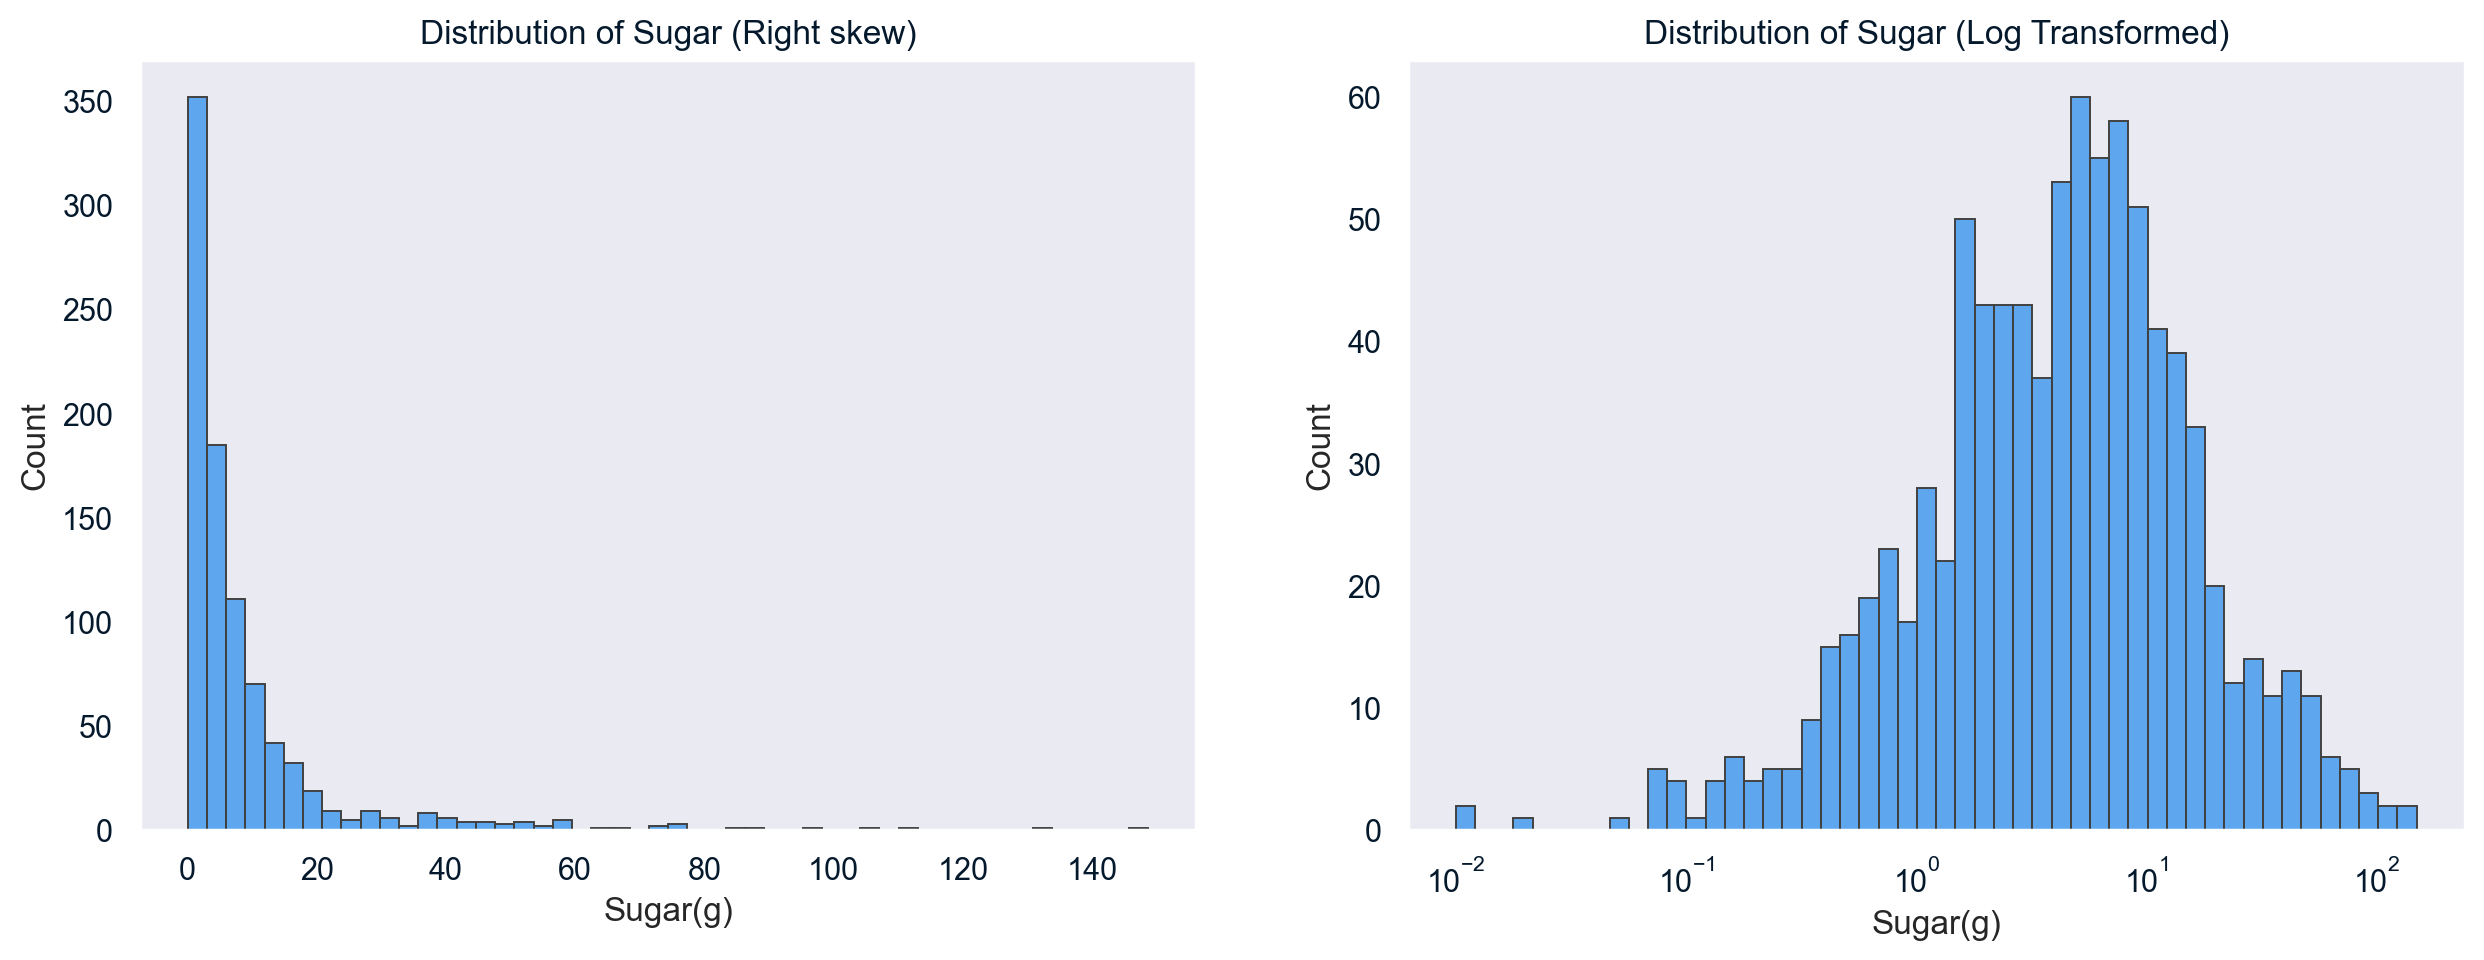

In [18]:
# histogram of 'sugar', the highest-skewed column, before and after log transformation
sns.set_context('notebook')
sns.set_style('dark')
fig, axes = plt.subplots(1, 2, figsize=(15,5))
sns.histplot(letmecook['sugar'], bins=50, color='#2f91ed', edgecolor='.25',ax=axes[0],).set(
xlabel='Sugar(g)', ylabel='Count', title='Distribution of Sugar (Right skew)')

"""
plt.xlabel('Sugar(g)')
plt.ylabel('Count')
plt.title('Distribution of Sugar (Right Skew)')
"""
sns.histplot(letmecook['sugar'], log_scale=True, bins=50, color='#2f91ed', edgecolor='.25', ax=axes[1],).set(
xlabel='Sugar(g)', ylabel='Count', title='Distribution of Sugar (Log Transformed)')

plt.show()

## Frequency of Food Groupings

### Single Variable 2: Count Plot of Provided Food Groupings
The count plot below shows that 'Chicken' is the most frequent food grouping in `category`, with 163 entries. This was the group that was consolidated with 'Chicken Breast'. The rest of the categories have comparably lower frequencies, dropping to 106 and steadily decreasing until the least frequent food grouping, 'One Dish Meal', with 67 entries.

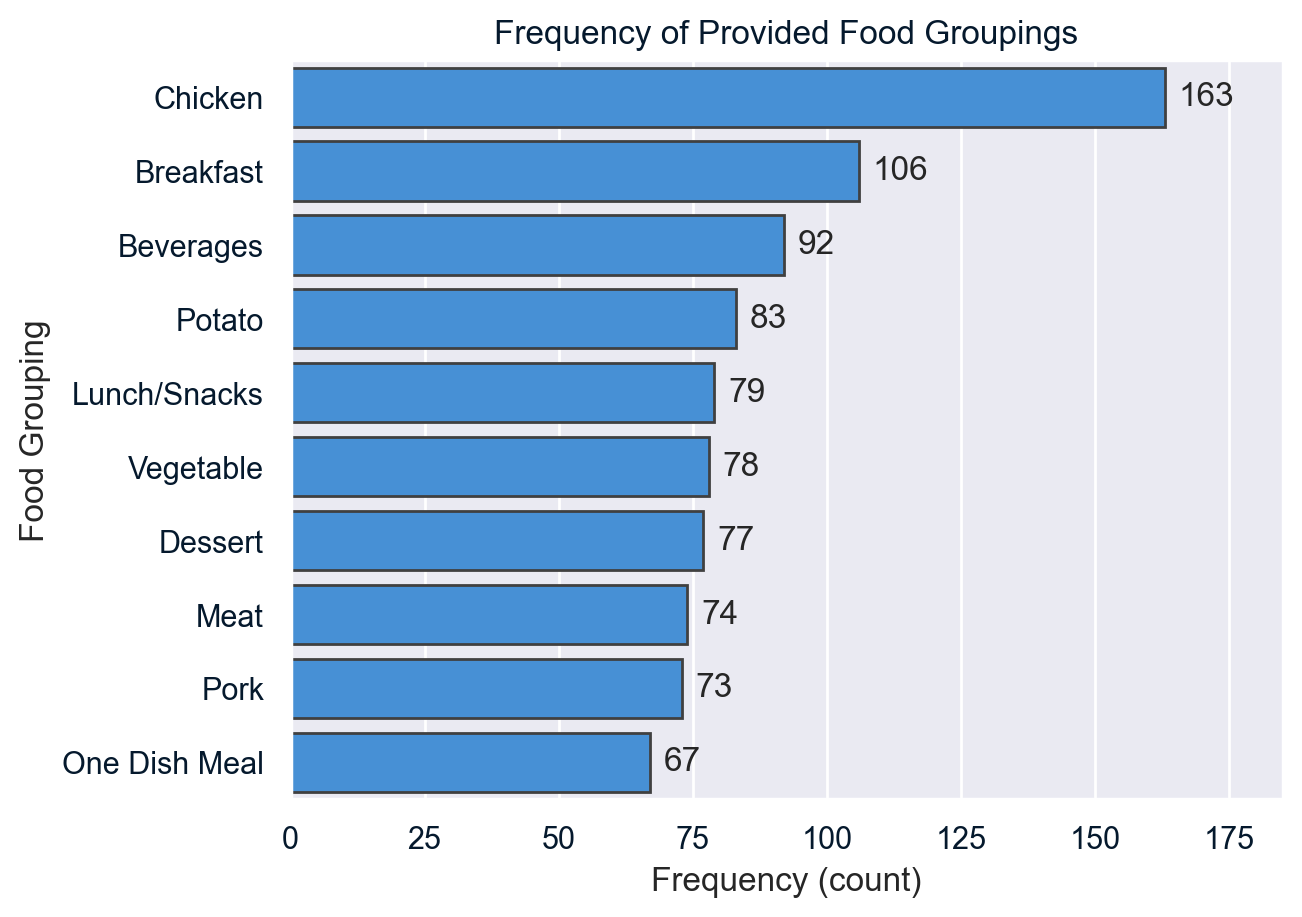

In [19]:
# count plot by 'category' of recipe
sns.set_style('darkgrid')
ax = sns.countplot(letmecook['category'],order=letmecook['category'].value_counts().index, color='#2f91ed', edgecolor='.25')
plt.xlabel('Frequency (count)')
plt.ylabel('Food Grouping')
plt.title('Frequency of Provided Food Groupings')
freq_labels = letmecook['category'].value_counts().values
ax.bar_label(container=ax.containers[0], labels=freq_labels, padding=5)
ax.set_xlim([0, 185])
plt.show()

## Numeric Correlation

### Multiple Variable 1: Correlation Heatmaps
Below are two heatmaps displaying linear (left) and logarithmic (right) correlation of numeric variables using Spearman's rank correlation.

Both graphs are very similar. There appears to be very weak linear and logarithmic correlation between most numeric variables and the target variable.
- Highest correlation with target variable: `high_traffic` vs. `protein` (0.12)
- Highest correlation overall: `calories` vs. `protein` (0.20)
- (Same for both linear and logarithmic correlation)

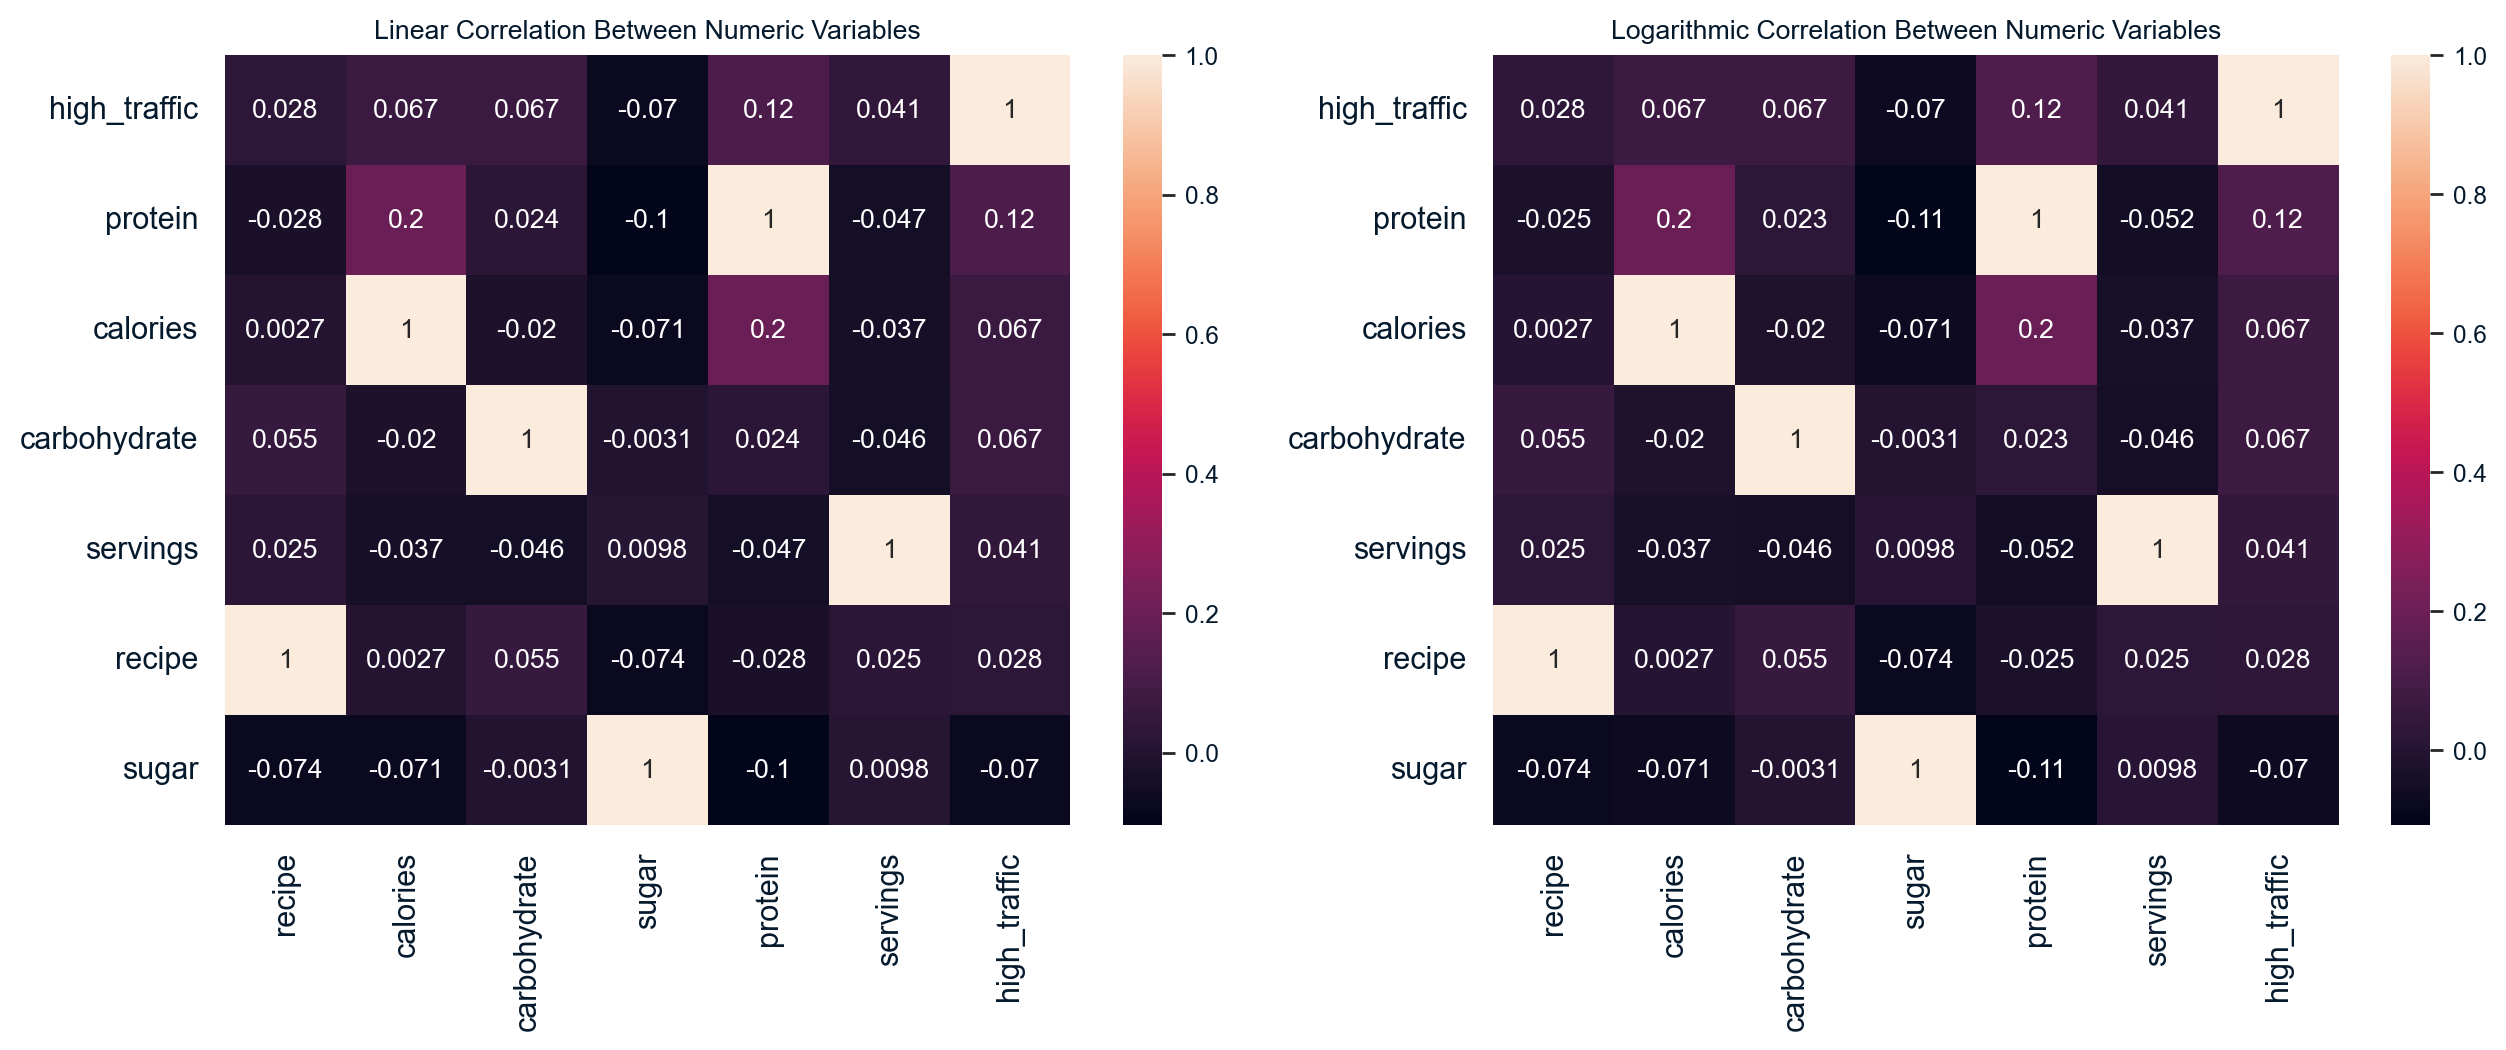

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
sns.set_context('paper')

# spearman less reliant on normality
recipe_corr = letmecook.corr(method='spearman').sort_values('high_traffic',ascending=False)
sns.heatmap(recipe_corr, ax=axes[0], annot=True).set(title='Linear Correlation Between Numeric Variables')

# log adjusted
log_adjusted = letmecook.copy()
log_adjusted[['recipe', 'calories', 'carbohydrate', 'sugar', 'protein', 'servings']] = log_adjusted[['recipe', 'calories', 'carbohydrate', 'sugar', 'protein', 'servings']].apply(np.log)

log_corr = log_adjusted.corr(method='spearman').sort_values('high_traffic', ascending=False)
sns.heatmap(log_corr, ax=axes[1], annot=True).set(title='Logarithmic Correlation Between Numeric Variables')
plt.show()

## Categorical Correlation

### Multiple Variable 2: Proportion of High Traffic by Category
The bar plots below show the proportion of `high_traffic` recipes for grouped values in the columns `category` (left) and `servings` (right).
- `category`: Categories appear to vary significantly. Atlmost all 'Vegetable' recipes seem to have `high_traffic`, while 'Beverages' have a very low proportion of `high_traffic` recipes.
- `servings`: Serving size category does not appear strongly correlated with `high_traffic`. All four values in `servings` have a proportion around 0.6, but the columns cannot confidently be compared due to overlapping error bars.

Note: `servings` was evaluated for both numeric and categorical correlation to determine if either numeric weight or categorical classification are correlated.

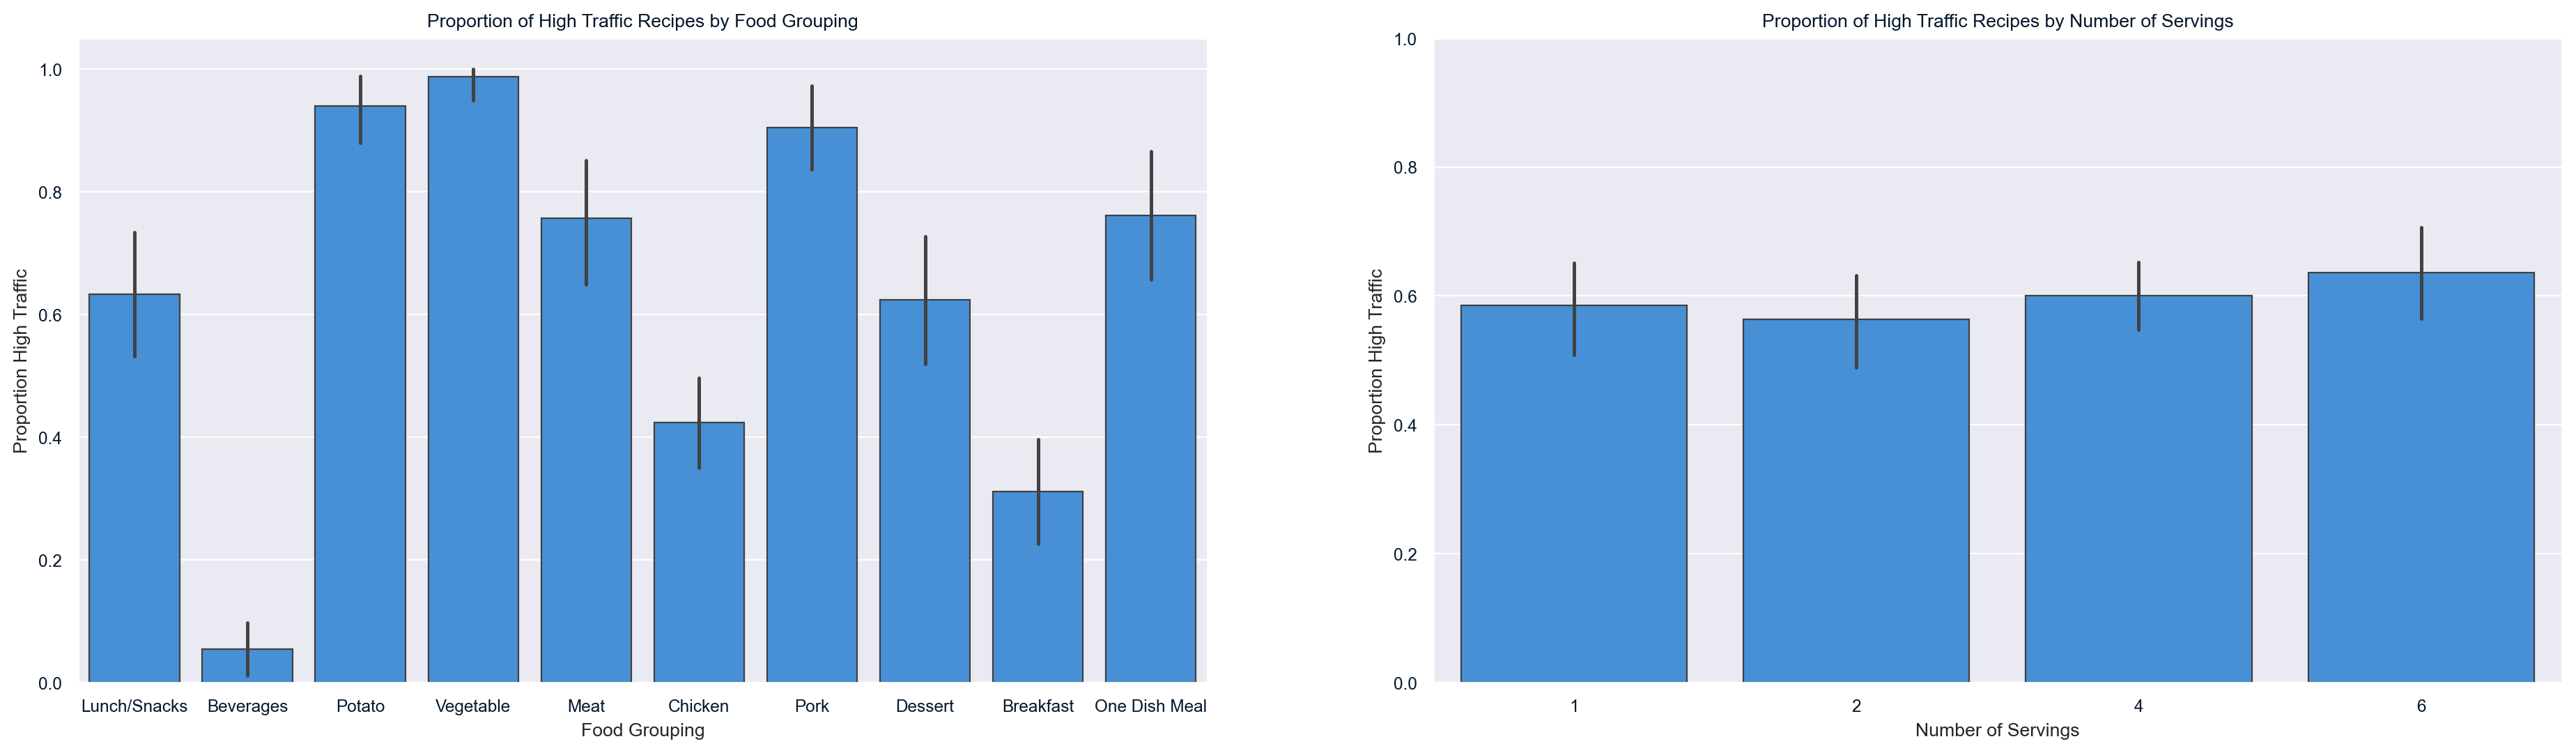

In [21]:
# barplot of 'high_traffic' vs. 'category'
fig, axes = plt.subplots(1, 2, figsize=(23,6))
sns.set_context('paper')
sns.set_style('darkgrid')
sns.barplot(x=letmecook['category'], y=letmecook['high_traffic'], ax=axes[0], color='#2f91ed', edgecolor='.25').set(xlabel='Food Grouping', ylabel='Proportion High Traffic', title='Proportion of High Traffic Recipes by Food Grouping')

sns.set_style('darkgrid')
ax = sns.barplot(x=letmecook['servings'], y=letmecook['high_traffic'], ax=axes[1], color='#2f91ed', edgecolor='.25').set(xlabel='Number of Servings', ylabel='Proportion High Traffic', title='Proportion of High Traffic Recipes by Number of Servings', ylim=[0,1])
#ax.figure(figsize=(5,10))

plt.show()

# Model Development
Predicting whether a recipe will lead to `high_traffic` is a binary classification, supervised learning problem.

Evaluation metrics
- **accuracy_score**: Baseline accuracy. May not be best evaluator with class imbalance of ~ 3/2 (True/False).
- **recall**: Tasty Bites asked if we can "correctly predict high traffic recipes 80% of the time", also known as a sensitivity/recall of 80%.
- **roc_auc_score** to quantify True Positive vs. False Positive rate at various thresholds of classification.

These performance metrics should be suitable for evaluating a binary classifier using this dataset with similarly-sized binary outcomes and ensure the results are not due to chance alone.

## Preprocessing

Create, dummy variables, scale using RobustScaler (StandardScaler too sensitive to outliers), and split into training and test sets.

In [22]:
# copy df for modelling
letmemodel = letmecook.copy()

# drop unique identifier
letmemodel = letmemodel.drop('recipe', axis=1)

# one-hot encode 'category'
let_dum = pd.get_dummies(letmemodel['category'])
letmemodel = pd.concat([letmemodel, let_dum], axis=1)
letmemodel = letmemodel.drop('category', axis=1)
letmemodel.head()

,calories,carbohydrate,sugar,protein,servings,high_traffic,Lunch/Snacks,Beverages,Potato,Vegetable,Meat,Chicken,Pork,Dessert,Breakfast,One Dish Meal
1,35.48,38.56,0.66,0.92,4,True,0,0,1,0,0,0,0,0,0,0
2,914.28,42.68,3.09,2.88,1,False,0,0,0,0,0,0,0,0,1,0
3,97.03,30.56,38.63,0.02,4,True,0,1,0,0,0,0,0,0,0,0
4,27.05,1.85,0.80,0.53,4,False,0,1,0,0,0,0,0,0,0,0
5,691.15,3.46,1.65,53.93,2,True,0,0,0,0,0,0,0,0,0,1


In [23]:
# split feature and target data

# X, feature data
X = letmemodel.drop('high_traffic', axis=1)

# y, target variable
y = letmemodel['high_traffic']

In [24]:
# split into training and test data
from sklearn.model_selection import train_test_split

seed = 3179

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)

In [25]:
# scale with RobustScaler
from sklearn.preprocessing import RobustScaler

robust = RobustScaler()

train_to_scale = X_train[['calories', 'carbohydrate', 'sugar', 'protein']]
test_to_scale = X_test[['calories', 'carbohydrate', 'sugar', 'protein']]


X_train_scaled = robust.fit_transform(train_to_scale)
X_test_scaled = robust.transform(test_to_scale)
# test data not used to fit scaler (prevent data leakage)

X_train[['calories', 'carbohydrate', 'sugar', 'protein']] = X_train_scaled
X_test[['calories', 'carbohydrate', 'sugar', 'protein']] = X_test_scaled

X_train.describe()

,calories,carbohydrate,sugar,protein,servings,Lunch/Snacks,Beverages,Potato,Vegetable,Meat,Chicken,Pork,Dessert,Breakfast,One Dish Meal
count,624.000000,6.240000e+02,6.240000e+02,6.240000e+02,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000
mean,0.300766,3.842130e-01,6.079682e-01,5.338861e-01,3.522436,0.080128,0.096154,0.099359,0.086538,0.075321,0.187500,0.091346,0.089744,0.126603,0.067308
std,0.909372,1.248080e+00,1.862014e+00,1.447079e+00,1.742531,0.271709,0.295039,0.299383,0.281383,0.264120,0.390626,0.288332,0.286043,0.332794,0.250755
min,-0.590169,-5.721366e-01,-5.076970e-01,-4.006284e-01,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.364917,-3.445072e-01,-3.145186e-01,-2.714061e-01,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.889752e-17,5.377643e-17,3.512815e-17,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.635083,6.554928e-01,6.854814e-01,7.285939e-01,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,6.624011,1.403056e+01,1.745065e+01,1.387117e+01,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Baseline Model: LogReg
Baseline is performing well. With a recall of more than 81%, model is already identifying more than 80% of the True Positive recipes, as requested by the customer. Decision-making is more superior than chance alone.

In [26]:
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, confusion_matrix

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_predlog = logreg.predict(X_test)

accuracylog = accuracy_score(y_test, y_predlog)
recall_log = recall_score(y_test, y_predlog)
auc_log = roc_auc_score(y_test, y_predlog)
conf_log = confusion_matrix(y_test,y_predlog)

def logreg_results():
    print(f'Baseline Logistic Regression Model\nAccuracy: {round(accuracylog,4)}\nRecall: {recall_log}\nROC AUC: {round(auc_log,4)}\n')
    print(f'Confusion Matrix\n{conf_log}')
logreg_results()

Baseline Logistic Regression Model
Accuracy: 0.7463
Recall: 0.8125
ROC AUC: 0.7303

Confusion Matrix
[[ 70  38]
 [ 30 130]]


In [27]:
# Model
logreg

LogisticRegression()

### LogReg Feature Importance
As expected from the lack of simple correlation found in exploratory analysis, numeric feature variables have very limited feature importance when applied to a logistic regression model.

`category`, which has been one-hot encoded, appears to be predominantly important in the model's decision-making. As expected, 'Beverages' and 'Vegetable' food groupings have the most-negative and most-positive impact, as they also had the lowest and highest proportion of `high_traffic` recipes, respectively.

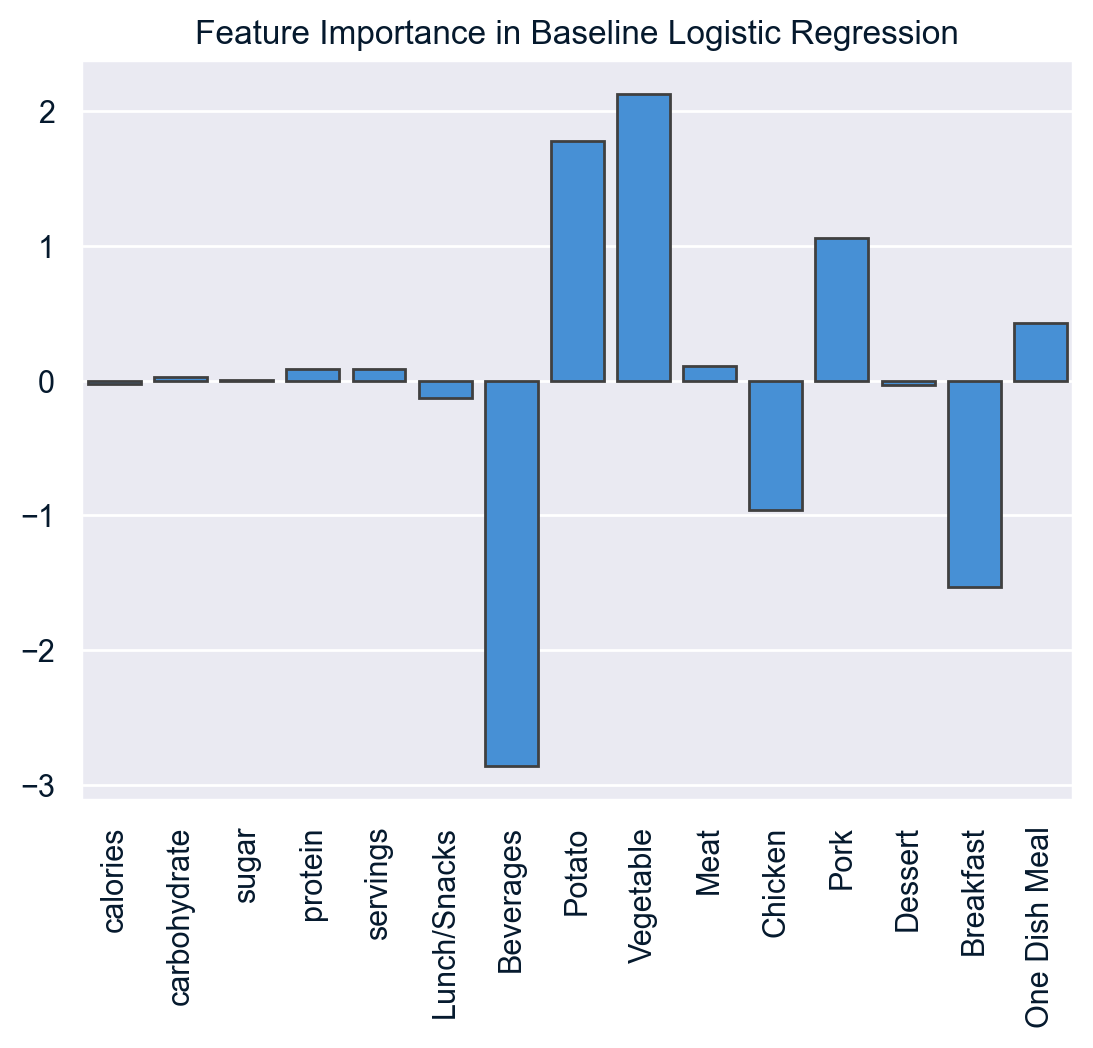

In [28]:
sns.set_context('notebook')
sns.barplot(x=logreg.feature_names_in_, y=logreg.coef_[0], color='#2f91ed', edgecolor='.25').set(title='Feature Importance in Baseline Logistic Regression')
sns.set_theme({'figure.figsize':(10, 5)})
plt.xticks(rotation=90)
plt.show()

## Random Forest Classifier Model

In [29]:
# Baseline random forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=seed)

rf.fit(X_train, y_train)

y_predrf = rf.predict(X_test)

accuracyrf = accuracy_score(y_test, y_predrf)
recall_rf = recall_score(y_test, y_predrf)
auc_rf = roc_auc_score(y_test, y_predrf)
conf_rf = confusion_matrix(y_test,y_predrf)

def baseline_rf_results():
    print(f'Baseline Random Forest Classifier Model\nAccuracy: {round(accuracyrf,4)}\nRecall: {recall_rf}\nROC AUC: {round(auc_rf,4)}\n')
    print(f'Confusion Matrix\n{conf_rf}')
baseline_rf_results()

Baseline Random Forest Classifier Model
Accuracy: 0.7463
Recall: 0.81875
ROC AUC: 0.7288

Confusion Matrix
[[ 69  39]
 [ 29 131]]


In [30]:
# Baseline RF
rf

RandomForestClassifier(random_state=3179)

### Hyperparameter Tuning
I used RandomizedSearchCV to cross-validate a Random Forest Classifier Model and test hyperparameters of 'n_estimators' and 'max_features'.

I scored this search using 'balanced_accuracy', or the average recall obtained for each binary outcome. While overall recall decreased, it remains above the desired 80% threshold with an improvement in overall accuracy and area under the ROC curve.

The highest-performing model, 'best_rf', utilizes all features and 750 estimators. 

In [31]:
# Tune hyperparameters and cross-validate
from sklearn.model_selection import KFold, RandomizedSearchCV

kf = KFold(n_splits=10, shuffle=True, random_state=seed)
param_grid = {'random_state': [seed], 'n_estimators': np.arange(50,1000,50), 'max_features': [None,'sqrt',2]}
rf2 = RandomForestClassifier()
rf_cv = RandomizedSearchCV(rf2, param_distributions=param_grid, cv=kf, scoring='balanced_accuracy', random_state=seed)

rf_search = rf_cv.fit(X_train, y_train)

y_predcv = rf_search.predict(X_test)

accuracycv = accuracy_score(y_test, y_predcv)
recall_cv = recall_score(y_test, y_predcv)
auc_cv = roc_auc_score(y_test, y_predcv)
conf_cv = confusion_matrix(y_test,y_predcv)

def rf_results():
    print(f'Random Forest Classifier Model\nAccuracy: {round(accuracycv,4)}\nRecall: {recall_cv}\nROC AUC: {round(auc_cv,4)}\n')
    print(f'Confusion Matrix\n{conf_cv}')
rf_results()

Random Forest Classifier Model
Accuracy: 0.7537
Recall: 0.81875
ROC AUC: 0.7381

Confusion Matrix
[[ 71  37]
 [ 29 131]]


In [32]:
# Best RF
best_rf = rf_search.best_estimator_
best_rf

RandomForestClassifier(max_features=None, n_estimators=750, random_state=3179)

### Feature Importance
The most important features in this Random Forest Classifier appear to be the four numeric columns that originally had some missing entries (`calories`, `carbohydrate`, `sugar`, `protein`). The 'Beverage' food grouping has nearly similar importance. Two other food groupings, 'Chicken' and 'Dessert', stand out to a lesser degree. Finally, the number of servings in `servings` also demonstrated some importance.

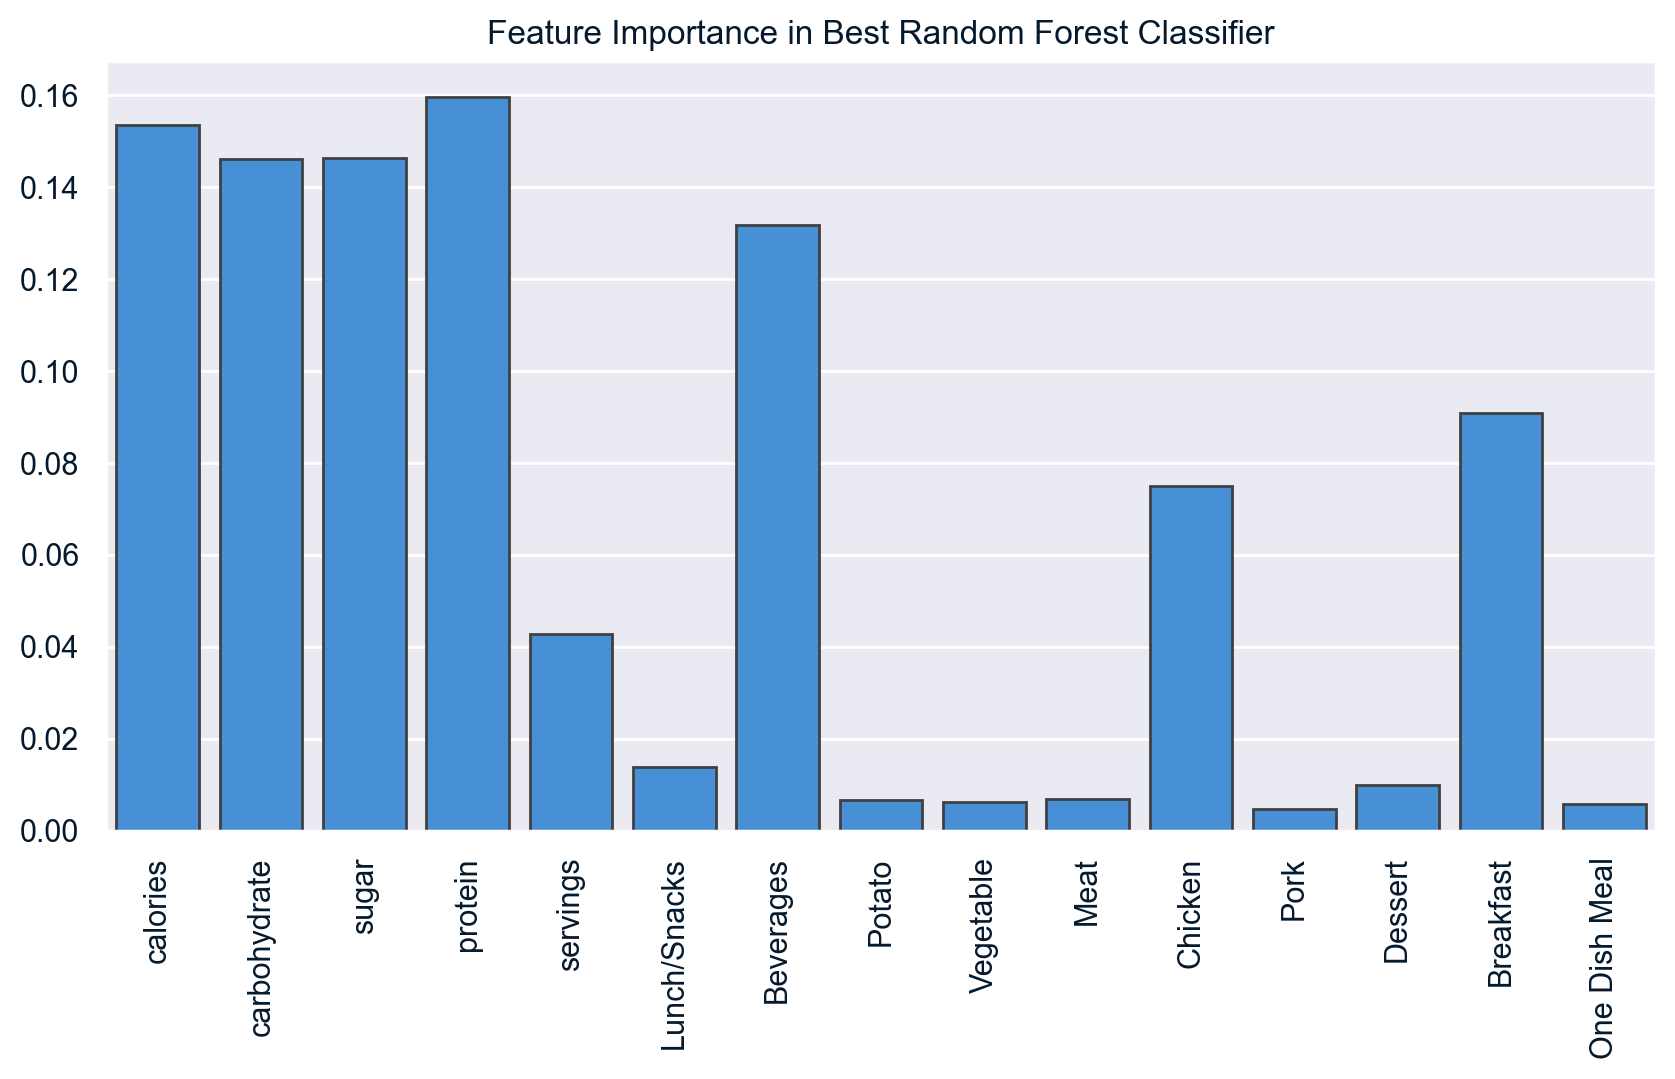

In [33]:
sns.barplot(x=best_rf.feature_names_in_, y=best_rf.feature_importances_, color='#2f91ed', edgecolor='.25').set(title='Feature Importance in Best Random Forest Classifier')
sns.set_theme({'figure.figsize':(10, 5)})
plt.xticks(rotation=90)
plt.show()

# Final Evaluation

## Model Comparison
Compared to the Baseline Logistic Regression Model, the Random Forest Classifier Model demonstrates slight improvements across all three chosen evaluation metrics: Accuracy, Recall, and ROC AUC.

This means the Random Forest Classifier is more accurate at determining whether a recipe is/isn't `high_traffic`, correctly predicts `high_traffic` recipes more often, and, across various classification thresholds, is more reliable than chance alone.

In [34]:
# Reprint results

# Baseline LogReg
logreg_results()

print('\n')

# Random Forest (tuned)
rf_results()

Baseline Logistic Regression Model
Accuracy: 0.7463
Recall: 0.8125
ROC AUC: 0.7303

Confusion Matrix
[[ 70  38]
 [ 30 130]]


Random Forest Classifier Model
Accuracy: 0.7537
Recall: 0.81875
ROC AUC: 0.7381

Confusion Matrix
[[ 71  37]
 [ 29 131]]


## Business Metrics
The customer asked if we could "correctly predict high traffic recipes 80% of the time". In the test set, the Random Forest Classifier correctly predicted 131 out of 160 `high_traffic`, resulting in a recall of 81.9%.

This is a helpful KPI to evaluate current and future iterations of this model. While keeping other metrics balanced, improving recall will reduce the proportion of false negative results and help to more consistently identify recipes that will increase website traffic and subscription purchases.

# Recommendations
This model exceeds the requests of the customer, and can be deployed immediately to help identify which recipes will result in `high_traffic` when featured. This should already provide significant benefit through featuring daily recipes that more consistently cause `high_traffic` and a resulting increase in subscription purchases. However, while testing this model in-field, it would be most beneficial to continue improving this model by asking some questions and gathering more data. Below is my plan moving forward:

Deployment
- One-off deployment should be very cost-effective until this model is updated. This model only has to be deployed on and utilized via customer's device(s) containing the website data.
- I will create a practical dashboard application with a simple user interface that allows the customer to pull new website/recipe data and view model predictions in the format they'd like, including visually pleasing and easily interpretable graphics.  

Collecting Additional Data
- Missing data: 52 entries are missing 4 columns of data with high feature importance. Why is this data missing? Can it be corrected?
- 'Time to make', 'Cost per serving', 'Ingredients': This information is displayed on the provided website example but was not included in the dataset. Perhaps it is relevant?

Feature Engineering
- `category`: I used the 10 food groupings that were provided, as the customer may deem it important that they be kept as specified. However, some groupings are not clear; it is unknown whether 'Chicken' and 'Pork' can be grouped into the 'Meat' category when nutritional metrics vary across these food groupings. Additionally, a recipe can only belong to one food grouping, but these groupings are not exclusive. For example, a recipe for chicken salad could potentially belong to 'Chicken', 'Vegetable', 'Meat', 'One dish meal', 'Lunch/Snacks', or more. This column should have likely been split into multiple features, such as meal-type (Breakfast, Lunch, Dinner) or a list of main ingredients, so each recipe is not limited to one, vague food grouping when no other qualitative information is available. 
- `high_traffic`: In the data provided, more than 60% of recipes lead to `high_traffic` (574/947). Perhaps the threshold of what it means to increase website traffic should be changed, so relevant features are more readily idenfitied before being generalized. Another option is to obtain more data to change to a regression problem, identifying how much a given recipe might increase traffic (customer insinuated they can quantify this increase in traffic). After all, it is more beneficial to choose recipes that increase traffic "by as much as 40%" rather than recipes that will produce a marginally smaller increase.

Improving the model
- Once more data is collected, can test other models to see if new data is a better fit for a different base model
- Perform an exhaustive GridSearchCV (instead of Random)
- Improve model stability using BaggingClassifier and OOB evaluation